In [539]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm 
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
 


pd.set_option('display.max_rows', None)  # Set to None to display all rows
pd.set_option('display.max_columns', None)  # Set to None to display all columns
import warnings
warnings.filterwarnings('ignore')
df=pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# Step 1 : Reading, understanding, visualising the Data 

### day.csv has the following fields:
	
- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	- weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

 #### Target Variable - cnt

In [474]:
# checking for nulls and datatype mismatch
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## Insight
- dteday can be dropped because all date related analysis is done already from column 2 to 7 
- there are no null values in any column 

### Transforming following columns as these are categorical later it will be converted to dummy columns 
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- weathersit : 
		- 1: Clear
		- 2: Mist
		- 3: Light Snow
		- 4: Heavy Rain
- Weekdays 0-Sunday ... 6- Saturday, because in data for 0 weekday workingday is marked as 0 and for weekday 1 workingday is also 1

In [478]:
df['season']=df['season'].map({1:"spring", 2:"summer", 3:"fall", 4:"winter" })
df['weathersit']=df['weathersit'].map({1: "Clear" , 2: "Mist" , 3: "Light_Snow" , 4: "Heavy_Rain"})
df['weekday']=df['weekday'].map({0:"Sun" , 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thurs", 5:"Fri", 6: "Sat"})

# dropping column instant as its just sequence number 
df=df.drop('instant', axis=1)

# dropping column dteday
df=df.drop('dteday', axis=1)

df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,spring,0,1,0,Sat,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,spring,0,1,0,Sun,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,spring,0,1,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,spring,0,1,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,spring,0,1,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [480]:
# As cnt = casual + registered , all 3 represent number of rental bookings, so these are sort of target variables for us. 
# But we are interested in total count only so we can remove casual and registered from dataset
# Including these variables in model building leads to data leakage.

df=df.drop('casual', axis=1)
df=df.drop('registered', axis=1)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,1,0,Sat,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,1,0,Sun,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,1,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,1,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,1,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


### Visualize Data 
- draw pair plots for numerical coloumns 
- draw boxplot to view categorical data
- Categorical features : season, yr, mnth, holiday, weekday, workingday, weathersit
- Numerical features : temp, atemp, hum, windspeed, casual, registered

In [483]:
cat_cols=['season','yr','mnth','holiday','weekday','workingday','weathersit']
num_cols=['temp','atemp','hum','windspeed','cnt']

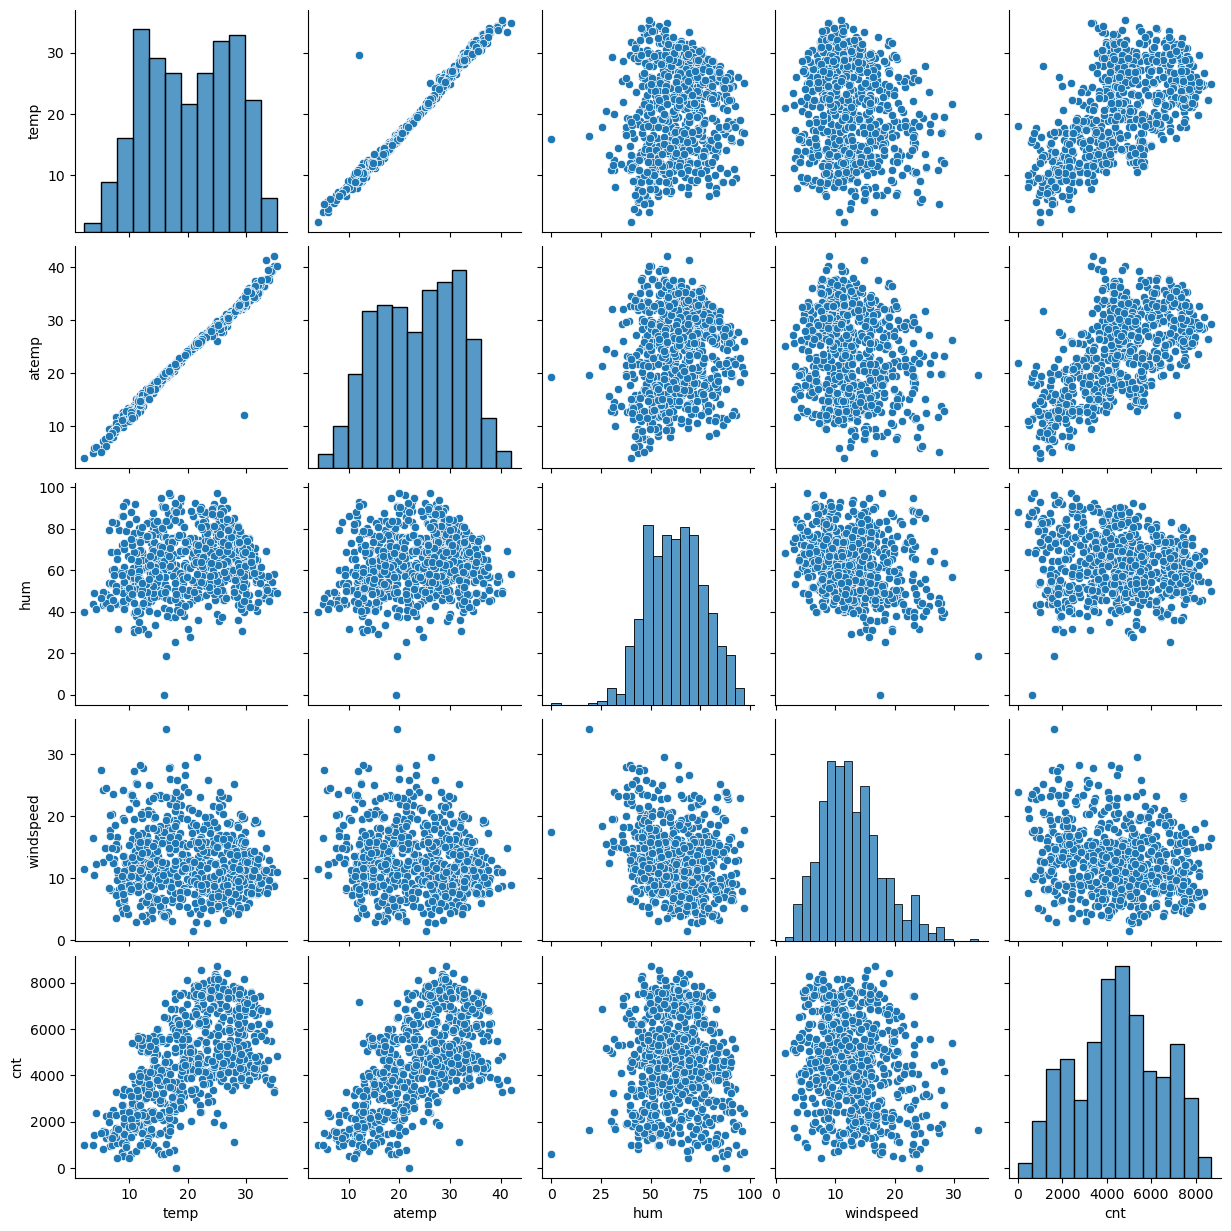

In [485]:
sns.pairplot(data=df[num_cols])

### Insight 
- cnt has some linear relation with atemp and temp
- atemp seems strongly related to temp linearly.

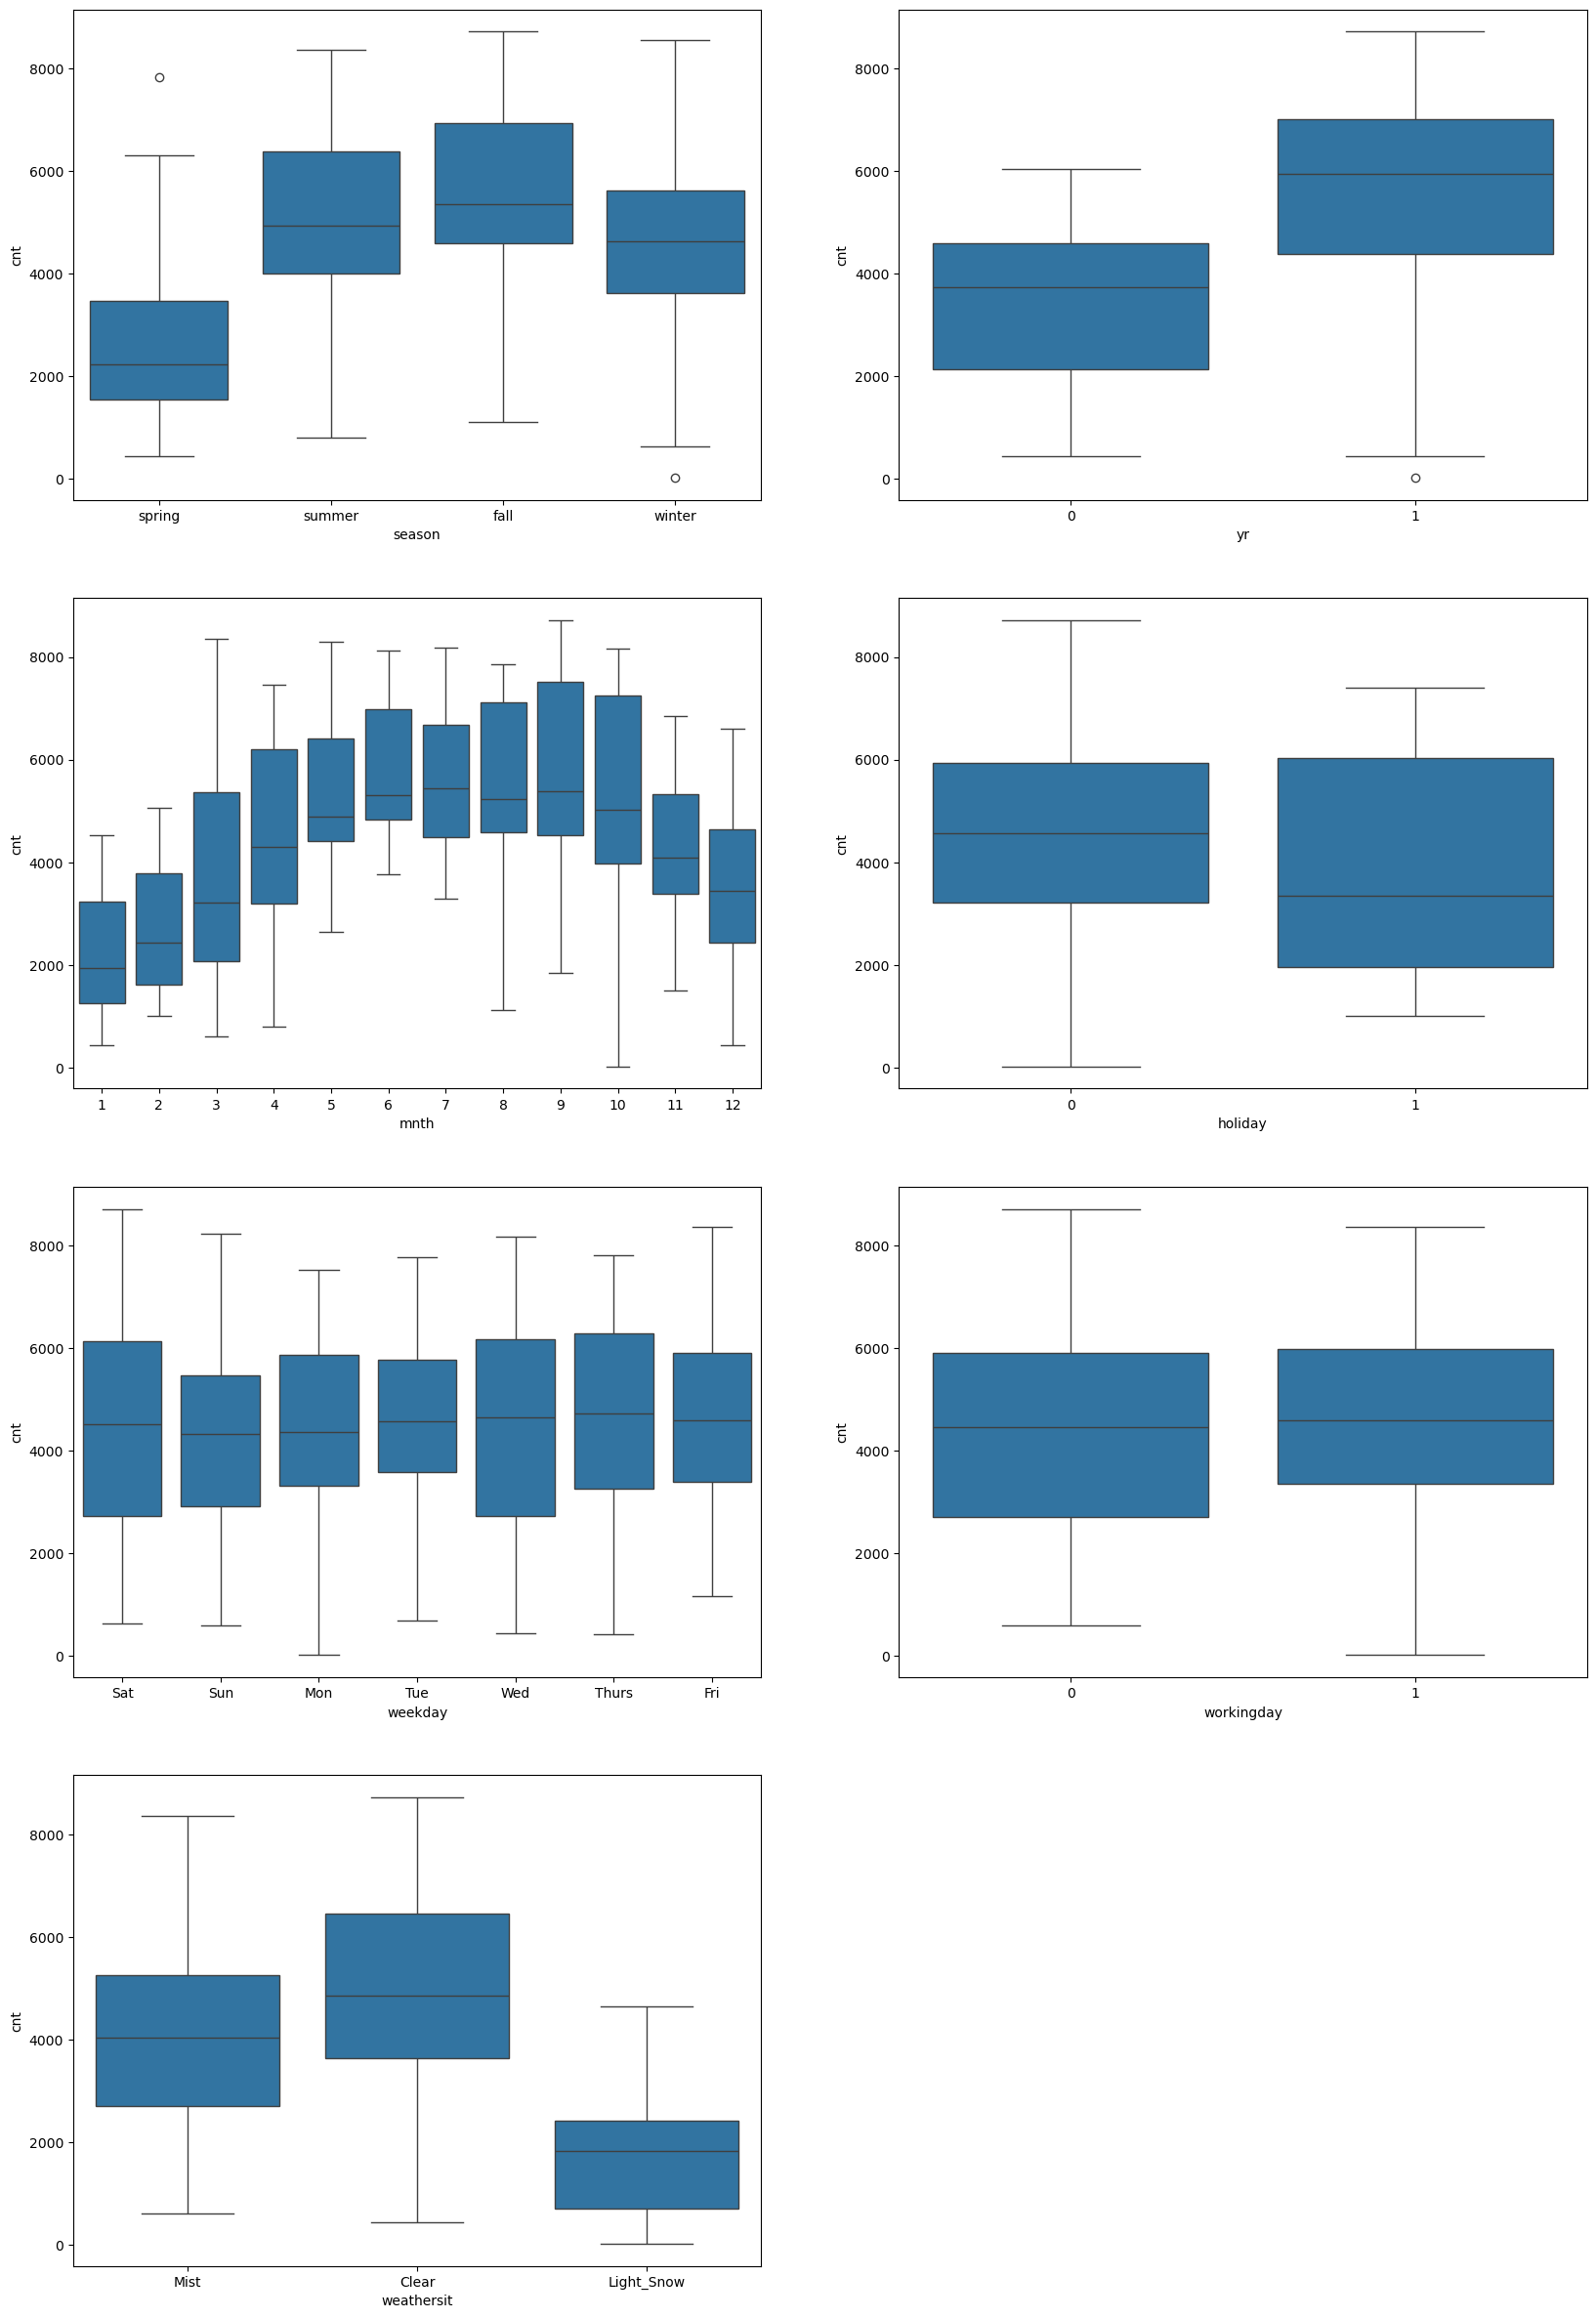

In [487]:
# to visualise categorical variable using box plot 

plt.figure(figsize=(20,30))
for i in range(len(cat_cols)) :
    plt.subplot(4,2,i+1)
    sns.boxplot(x=cat_cols[i],y='cnt',data=df)


plt.show()

### Insight
- cnt seems be be impacted by season
- number of rented bikes has increased from 2018 to 2019
- there is relation of cnt with month
- people seem to rent more bikes when its not a holiday
- more bikes are rented in clear weather

# Step 2 : Data Preparation
- convert binary columns values to 1/0 
- create dummy variables for multivalued categorical variables
- split the data into train and test
- rescale the features 

In [492]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,1,0,Sat,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,1,0,Sun,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,1,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,1,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,1,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [494]:
# creating dummy variables for season
season_list=pd.get_dummies(df['season'],drop_first=True).astype('int')
df=pd.concat([df,season_list],axis=1)
df=df.drop('season',axis=1)

# creating dummy variables for weathersit
weather_list=pd.get_dummies(df['weathersit'],drop_first=True).astype('int')
df=pd.concat([df,weather_list],axis=1)
df=df.drop('weathersit',axis=1)

# creating dummy variables for month
month_list=pd.get_dummies(df['mnth'],drop_first=True).astype('int')
df=pd.concat([df,month_list],axis=1)
df=df.drop('mnth',axis=1)

# creating dummy variables for weekday
weekday_list=pd.get_dummies(df['weekday'],drop_first=True).astype('int')
df=pd.concat([df,weekday_list],axis=1)
df=df.drop('weekday',axis=1)

# converting all column name types to string otherwise it throws error while model creation
df.columns = df.columns.astype(str)
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,Light_Snow,Mist,2,3,4,5,6,7,8,9,10,11,12,Mon,Sat,Sun,Thurs,Tue,Wed
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [496]:
# train test split for multi variable 
df_train,df_test = train_test_split(df,train_size=0.7,random_state=100)

In [498]:
print(df_train.shape)
print(df_test.shape)

(510, 30)
(220, 30)


### Rescaling the features
- min max scaling (normalisation) (x-xmin)/(xmax - xmin) ( between 0 and 1 ) 
- standardisation ( mean=0 , sigma =1 ) (x-mu)/ sigma
- as general rule of thumb its advisable to use min max scaling as it takes care of outliers
- generally we only scale numeric variable not the boolean columns. It happens automatically in normalisation.
#### Most sklearn classes have following methods
- most sklearn classes work in 2 steps 1- create object 2- process
- fit()  : learns xmin , xmax
- transform() : calculates normalised value
- fit_transform()
- for training data we fit and transform
- for test data we use the training scales and only transform
- we never fit for test data 

In [501]:
scaler = MinMaxScaler()

# fit on training data 
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,Light_Snow,Mist,2,3,4,5,6,7,8,9,10,11,12,Mon,Sat,Sun,Thurs,Tue,Wed
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


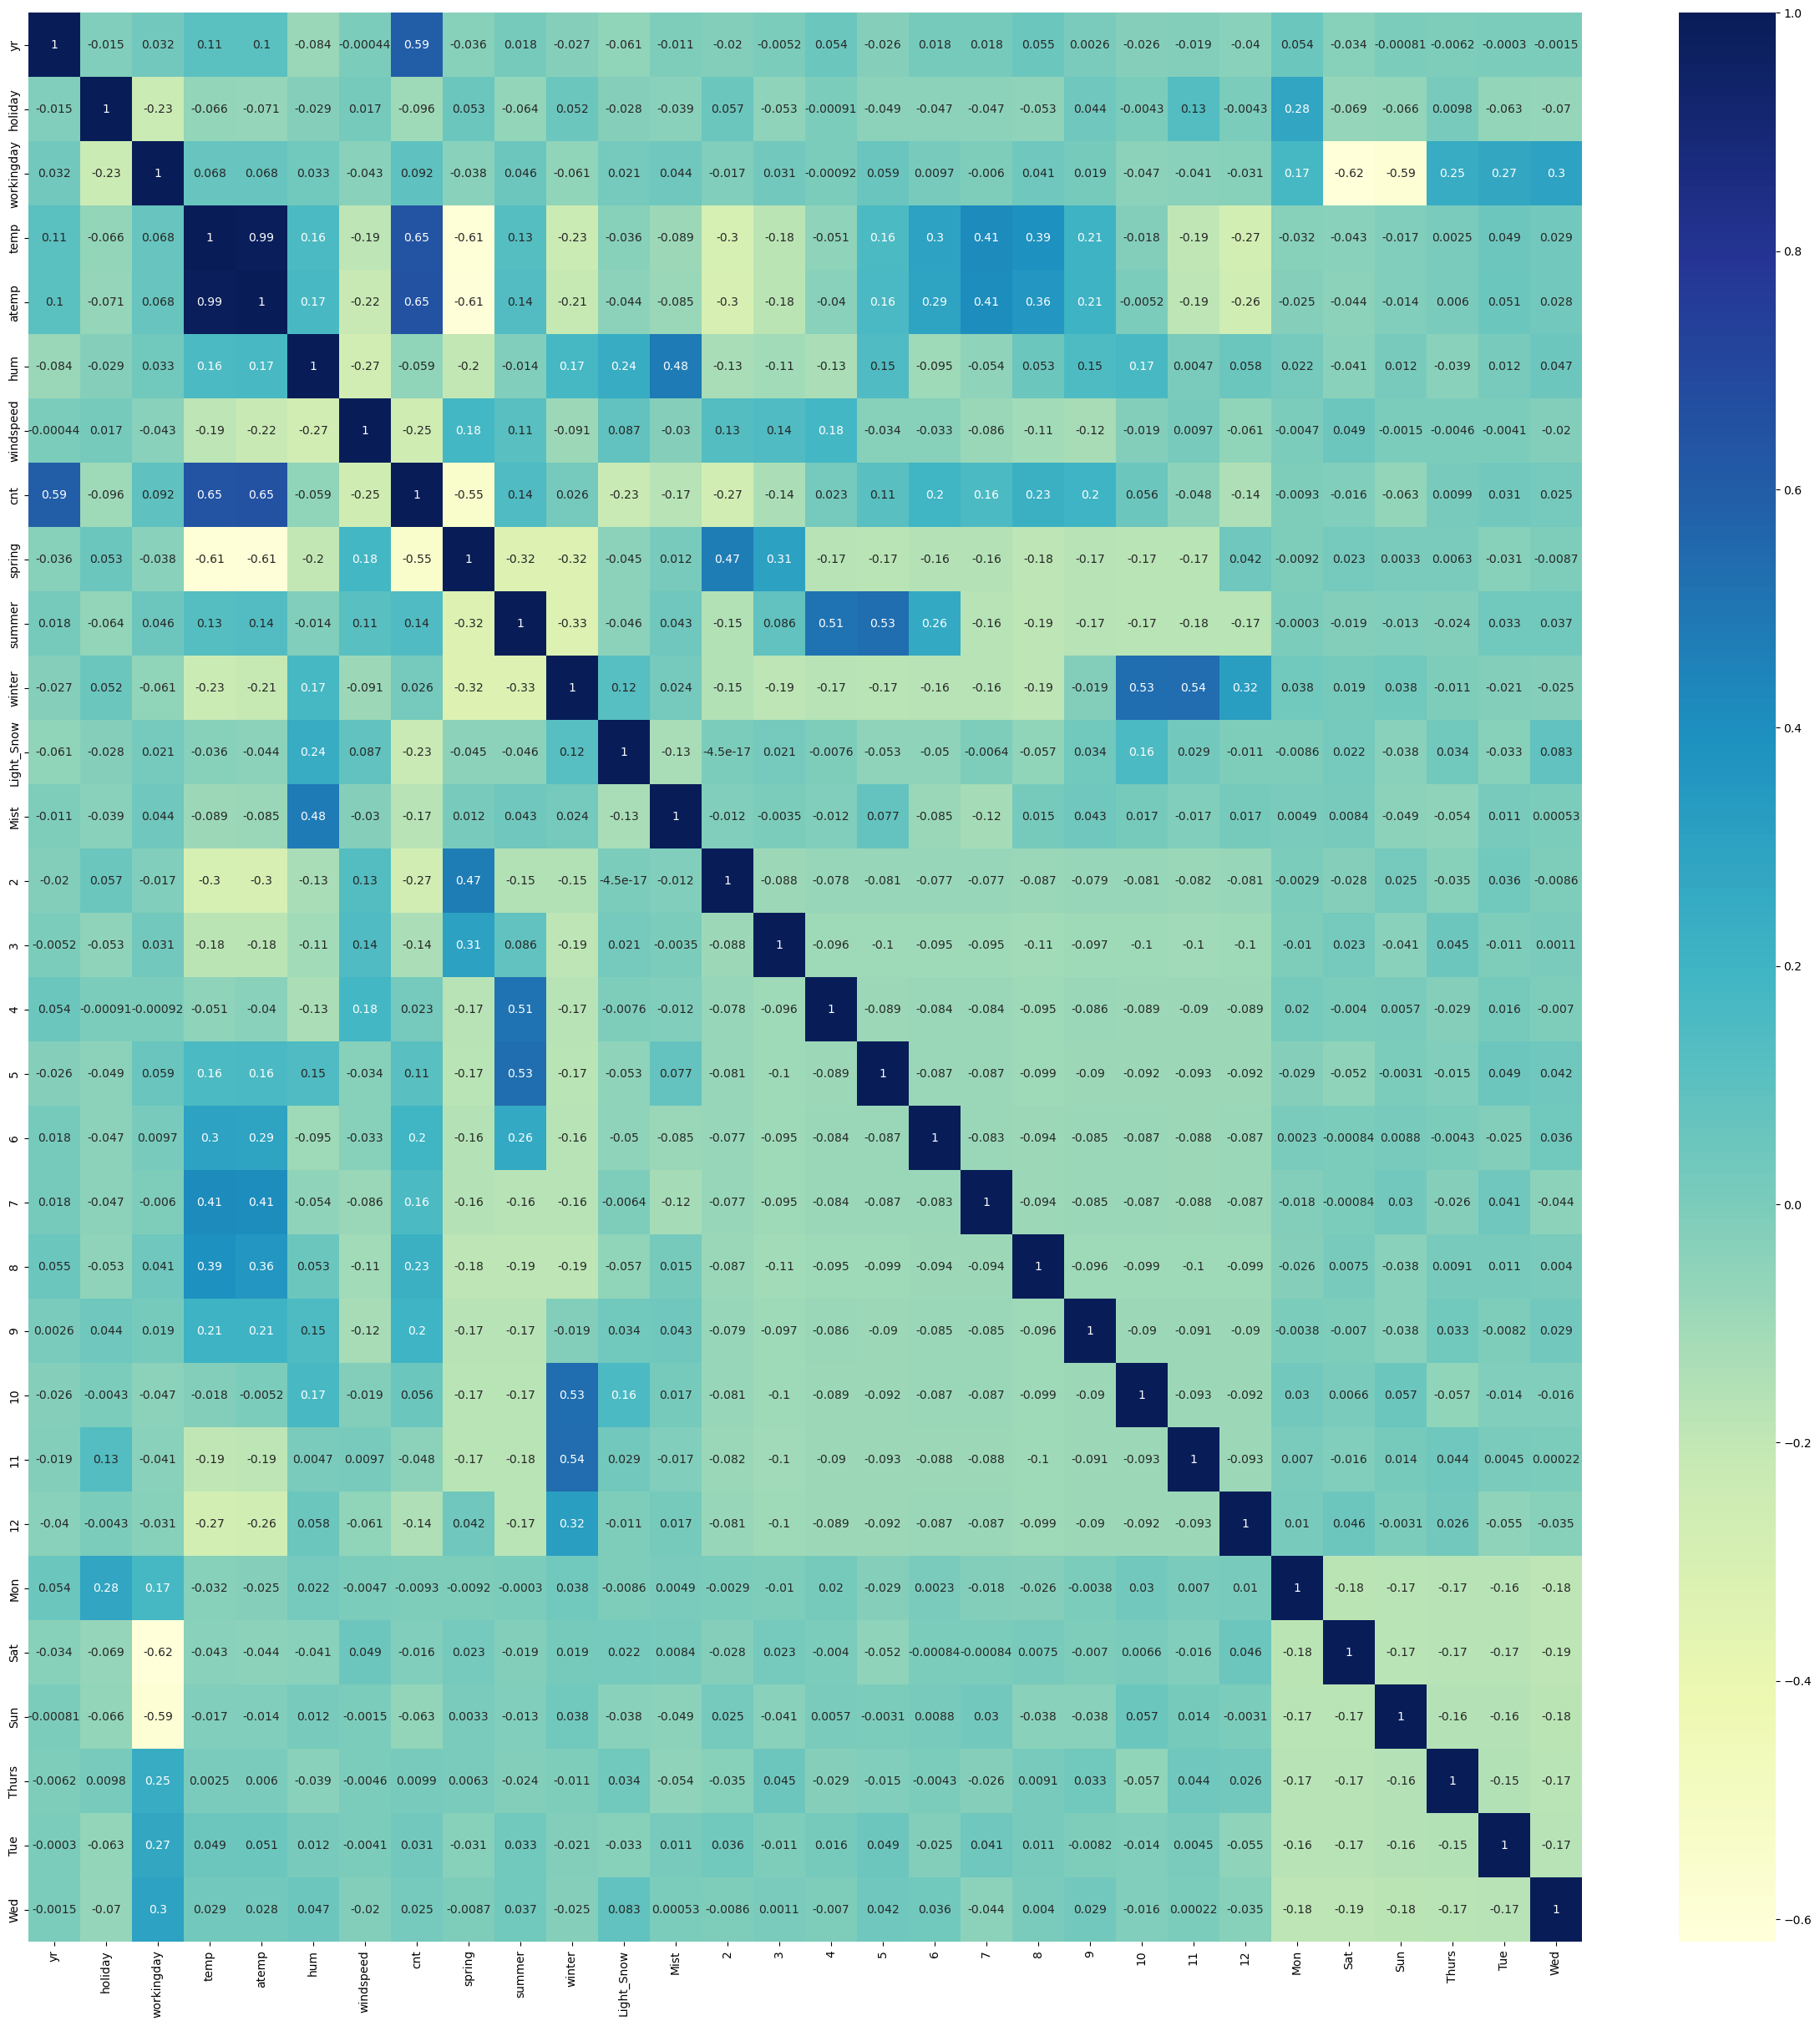

In [503]:
# Heatmap of correlation matrix will tell us inter-relationship between variables.
plt.figure(figsize = (30, 30))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

### Insight 
- cnt is highly correlated to temperature and year 

# Step 3 : Training the model 
- We will use a combination of automated(RFE) and manual method of feature selection. This is because there are a lot of features ( more than 10 ).
- then we will train the model using statsmodel.api
- We will look at statistical significance of variables
- if one variable is correlated to many other variables so we need to look at VIF
- if p-value and VIF score are conflicting then we use following order
  - 1- high p-value , low VIF :because once we remove insignificant variables VIF may change and high correlation doesnt impact the predictions and accuracy of model.
  - 2- low p-value , high VIF

In [507]:
# define X_train, y_train

y_train= df_train.pop('cnt')
X_train=df_train

In [509]:
lm=LinearRegression()
lm.fit(X_train, y_train)
rfe=RFE(estimator=lm, n_features_to_select=10) # asking RFE to select top 10 predictors 
rfe=rfe.fit(X_train,y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 12),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', False, 7),
 ('summer', False, 3),
 ('winter', True, 1),
 ('Light_Snow', True, 1),
 ('Mist', False, 4),
 ('2', False, 13),
 ('3', False, 8),
 ('4', False, 11),
 ('5', False, 9),
 ('6', False, 10),
 ('7', False, 16),
 ('8', False, 5),
 ('9', False, 2),
 ('10', False, 6),
 ('11', False, 20),
 ('12', False, 17),
 ('Mon', False, 14),
 ('Sat', True, 1),
 ('Sun', True, 1),
 ('Thurs', False, 19),
 ('Tue', False, 15),
 ('Wed', False, 18)]

In [511]:
rfe_cols=X_train.columns[rfe.support_]
X_train_rfe=X_train[rfe_cols]
X_train_rfe=sm.add_constant(X_train_rfe)
lm =sm.OLS(y_train,X_train_rfe).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     224.8
Date:                Tue, 19 Nov 2024   Prob (F-statistic):          1.81e-169
Time:                        12:54:34   Log-Likelihood:                 451.67
No. Observations:                 510   AIC:                            -883.3
Df Residuals:                     500   BIC:                            -841.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1821      0.023      7.900      0.0

In [513]:
# Calculating VIF
vif=pd.DataFrame()
vif['Features']=X_train_rfe.columns
vif['VIF']=[variance_inflation_factor(X_train_rfe.values,i) for i in range(X_train_rfe.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif = vif.sort_values( by= 'VIF', ascending=False)
vif

,Features,VIF
2,holiday,inf
3,workingday,inf
9,Sat,inf
10,Sun,inf
5,hum,1.23
4,temp,1.16
6,windspeed,1.14
7,winter,1.13
8,Light_Snow,1.11
1,yr,1.03


### Insights about Model 1 
- Coefficients: ok. none of the coeffients are too large or too small. 
- p-value : holiday has p-value > 0.05 so its insignificant
- VIF: is high for holiday, workingday, sat, sun which indicates multicollinearity.
- Action: p-value has higher preference than VIF so removing "holiday". VIF may change after re-training.

In [516]:
# removing holiday as p-value is high hence it is insignificant 
exclude_cols=['holiday']
X_train_rfe=X_train_rfe.drop(exclude_cols,axis=1)
X_train_rfe.head()

,const,yr,workingday,temp,hum,windspeed,winter,Light_Snow,Sat,Sun
576,1.0,1,1,0.815169,0.725633,0.264686,0,0,0,0
426,1.0,1,0,0.442393,0.640189,0.255342,0,0,1,0
728,1.0,1,0,0.245101,0.498067,0.663106,0,0,0,1
482,1.0,1,0,0.395666,0.504508,0.188475,0,0,1,0
111,1.0,0,1,0.345824,0.751824,0.380981,0,0,0,0


In [518]:
X_train_rfe=sm.add_constant(X_train_rfe)
lm =sm.OLS(y_train,X_train_rfe).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     224.8
Date:                Tue, 19 Nov 2024   Prob (F-statistic):          1.81e-169
Time:                        12:54:40   Log-Likelihood:                 451.67
No. Observations:                 510   AIC:                            -883.3
Df Residuals:                     500   BIC:                            -841.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1640      0.039      4.210      0.0

In [520]:
# Calculating VIF
vif=pd.DataFrame()
vif['Features']=X_train_rfe.columns
vif['VIF']=[variance_inflation_factor(X_train_rfe.values,i) for i in range(X_train_rfe.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif = vif.sort_values( by= 'VIF', ascending=False)
vif

,Features,VIF
0,const,76.14
2,workingday,8.99
8,Sat,6.01
9,Sun,5.69
4,hum,1.23
3,temp,1.16
5,windspeed,1.14
6,winter,1.13
7,Light_Snow,1.11
1,yr,1.03


### Insights about model 2
- Coefficients: ok 
- p-value : is high for Sun
- VIF: is high(>5) for workingday,Sat,Sun
- Action: Remove Sun and re-train the model 

In [523]:
# removing Sun as p-value > 0.5  
exclude_cols=['Sun']
X_train_rfe=X_train_rfe.drop(exclude_cols,axis=1)
X_train_rfe.head()
X_train_rfe=sm.add_constant(X_train_rfe)
lm =sm.OLS(y_train,X_train_rfe).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     251.4
Date:                Tue, 19 Nov 2024   Prob (F-statistic):          5.27e-170
Time:                        12:54:44   Log-Likelihood:                 450.07
No. Observations:                 510   AIC:                            -882.1
Df Residuals:                     501   BIC:                            -844.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2082      0.030      6.946      0.0

In [525]:
# Calculating VIF
vif=pd.DataFrame()
vif['Features']=X_train_rfe.columns
vif['VIF']=[variance_inflation_factor(X_train_rfe.values,i) for i in range(X_train_rfe.shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif = vif.sort_values( by= 'VIF', ascending=False)
vif

,Features,VIF
0,const,44.90
2,workingday,1.64
8,Sat,1.63
4,hum,1.23
3,temp,1.16
5,windspeed,1.14
6,winter,1.13
7,Light_Snow,1.11
1,yr,1.03


### Insights about model 3
- Coefficients: ok 
- p-value : ok. all p-values are equal to 0 means these predictors are significant.
- VIF: ok. As all VIF values are less than 5. VIF of constant can be ignored.
- R-square and adjusted R-square: ok. Both are close to 0.8 which means this model explains 80% variance in training data. 
- Action: This is a good model. We can proceed with residual analysis

# Step 4 : Residual Analysis
- In this step we will plot the error terms to see if it statisfies the required conditions for linear regression.
  - Error or residue = difference of "actual target value" and  "predicted target value"
- Conditions
  - Errors should be normally distributed
  - Mean of distribution should be zero
  - should have constant variance
- We will check if this holds good for both training and test dataset.
- Steps to be performed on test dataset
  - select the columns which are in final model
  - scale the test dataset : only transform , DO NOT fit 
  - Add constant
  - calculate residue and plot the chart

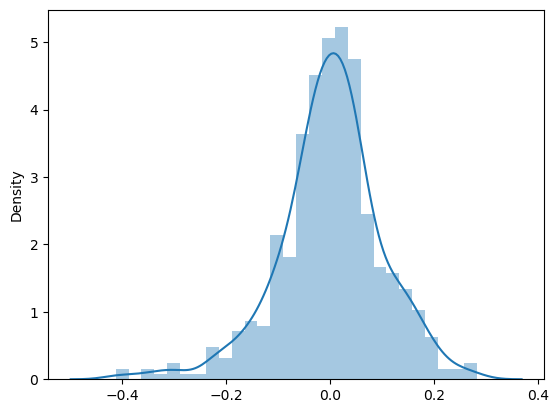

In [529]:
y_train_pred=lm.predict(X_train_rfe)
res=y_train - y_train_pred
sns.distplot(res)
plt.show()

### Making prediction on test data

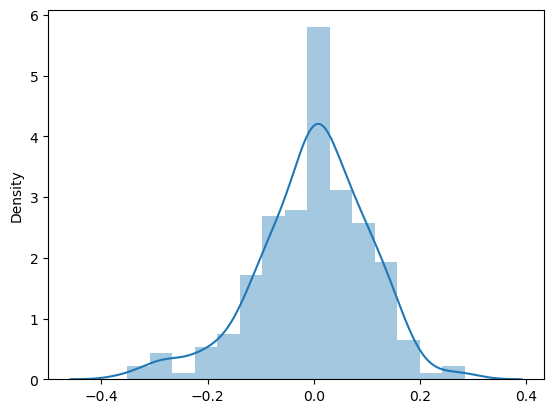

In [532]:
cols = ['yr','workingday','temp','hum','windspeed','winter','Light_Snow','Sat']
df_test[num_cols]=scaler.transform(df_test[num_cols])
y_test= df_test.pop('cnt')
X_test=df_test
X_test_new=X_test[cols]
X_test_new=sm.add_constant(X_test_new)
y_test_pred=lm.predict(X_test_new)
res=y_test - y_test_pred
sns.distplot(res)
plt.show()

Text(0, 0.5, 'y_pred')

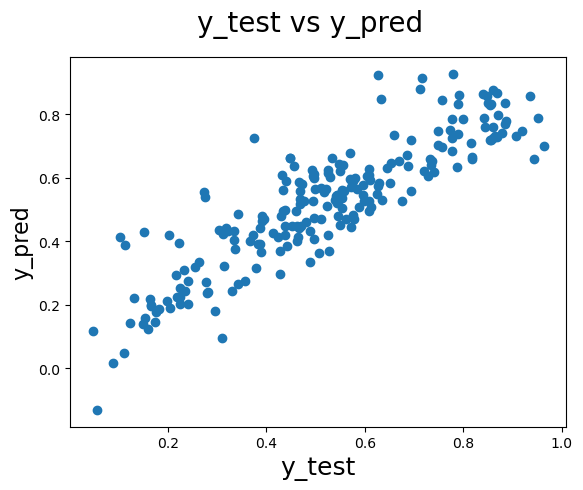

In [576]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)  

### Insights of Residual analysis 
- The conditions related to error terms are met for training and test data.
   - Errors are normally distributed.
   - Mean of errors is zero.
- Plot of y_pred vs y_test is distributed around a 45 degree line with no clear pattern which indicates that error terms have constant varience. The model is NOT over or under fitted.

# Step 5: Model Evaluation
- Calculate r-score for training and test data. If r-score is more that 0.5 than its a good model.
- Let's now plot the graph for actual versus predicted values.

In [543]:
r2_score_train=r2_score(y_true=y_train , y_pred=y_train_pred)
r2_score_test=r2_score(y_true=y_test,y_pred=y_test_pred)
print("r2_score_train=",r2_score_train)
print("r2_score_test=",r2_score_test)

r2_score_train= 0.8005987731727358
r2_score_test= 0.770872002138381


### Insights 
- R2 score for both training and test data is above 0.7 which indicates that model is generalised. It is able to explain more than 70% variance.


# Step 6 : Final model

cnt =  0.2082 + 0.2273 * yr + 0.0511 * workingday + 0.6270 * temp + (-0.2355) * hum + (-0.1876) * windspeed + 0.1163 * winter + (-0.2035) * Light_Snow + (0.0582) * Sat

# Step 7 : Inferences from Model 
     
- features which positively derive the bike rental
   - year
   - workingday
   - temperature
   - winter
   - Saturday
 
- Features which negatively derive the bike rental
   - humidity
   - windspeed
   - light_snow

- top 3 predictors of bike rental ( in order of absolute value of coefficients )
   - Temperature
   - humidity
   - year